# Mitigating Bias with AIF360


In [2]:
pip install --user aif360[all]

  Using cached sphinx_rtd_theme-1.0.0-py2.py3-none-any.whl (2.8 MB)
  Using cached cvxpy-1.2.0-cp39-cp39-win_amd64.whl (832 kB)
  Using cached tensorflow-2.8.0-cp39-cp39-win_amd64.whl (438.0 MB)
  Using cached BlackBoxAuditing-0.1.54-py2.py3-none-any.whl
  Using cached fairlearn-0.4.6-py3-none-any.whl (21.2 MB)
  Using cached adversarial_robustness_toolbox-1.10.0-py3-none-any.whl (1.3 MB)
  Using cached ecos-2.0.10-cp39-cp39-win_amd64.whl (68 kB)
  Using cached scs-3.2.0-cp39-cp39-win_amd64.whl (8.1 MB)
  Using cached osqp-0.6.2.post5-cp39-cp39-win_amd64.whl (278 kB)
  Using cached qdldl-0.1.5.post0-cp39-cp39-win_amd64.whl (74 kB)
  Using cached grpcio-1.45.0-cp39-cp39-win_amd64.whl (3.5 MB)
  Using cached tensorboard-2.8.0-py3-none-any.whl (5.8 MB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached termcolor-1.1.0-py3-none-any.whl
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached flatbuffers-2.0-py2.py3-none-any.whl (26 kB)
 

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


### Loading and preparing the dataset

In [1]:
# First, read-in the data and check for null values
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import aif360
from aif360.algorithms.preprocessing import DisparateImpactRemover
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
pd.options.mode.chained_assignment = None  # default='warn', silencing Setting With Copy warning

In [2]:
df = pd.read_csv("heart_disease.csv")
df

,Unnamed: 0,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,0,63,male,3,145.0,233.0,1,0,150.0,0,2.3,0,0,1,yes
1,1,37,male,2,130.0,250.0,0,1,187.0,0,3.5,0,0,2,yes
2,2,41,female,1,130.0,204.0,0,0,172.0,0,1.4,2,0,2,yes
3,3,56,male,1,120.0,236.0,0,1,178.0,0,0.8,2,0,2,yes
4,4,57,female,0,NaN,354.0,0,1,163.0,1,0.6,2,0,2,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,298,57,female,0,140.0,241.0,0,1,123.0,1,0.2,1,0,3,no
299,299,45,male,3,110.0,264.0,0,1,132.0,0,1.2,1,0,3,no
300,300,68,male,0,144.0,193.0,1,1,141.0,0,3.4,1,2,3,no
301,301,57,male,0,NaN,131.0,0,1,115.0,1,1.2,1,1,3,no


(303, 15)

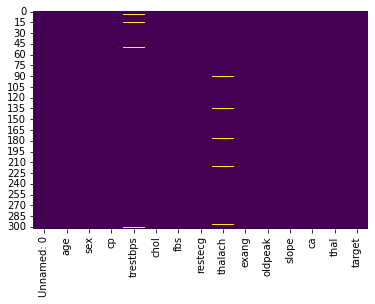

In [3]:
#check for null entries

sns.heatmap(df.isnull(),cbar=False,cmap='viridis')

df.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 293 entries, 0 to 302
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  293 non-null    int64  
 1   age         293 non-null    int64  
 2   sex         293 non-null    object 
 3   cp          293 non-null    int64  
 4   trestbps    293 non-null    float64
 5   chol        293 non-null    float64
 6   fbs         293 non-null    int64  
 7   restecg     293 non-null    int64  
 8   thalach     293 non-null    float64
 9   exang       293 non-null    int64  
 10  oldpeak     293 non-null    float64
 11  slope       293 non-null    int64  
 12  ca          293 non-null    int64  
 13  thal        293 non-null    int64  
 14  target      293 non-null    object 
dtypes: float64(4), int64(9), object(2)
memory usage: 36.6+ KB


<AxesSubplot:>

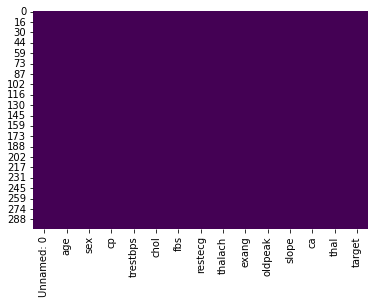

In [4]:
# Remove rows with null values
df = df.dropna(how='any', axis = 0)
df.info()
sns.heatmap(df.isnull(),cbar=False,cmap='viridis')

I then want to check to see the breakdown of values for the outcome variable, `Loan_Status`.

In [5]:
target_counts = df['target'].value_counts()
target_counts

yes    160
no     133
Name: target, dtype: int64

In [6]:
# Drop unnecessary column
df = df.drop(['Unnamed: 0'], axis = 1)
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,male,3,145.0,233.0,1,0,150.0,0,2.3,0,0,1,yes
1,37,male,2,130.0,250.0,0,1,187.0,0,3.5,0,0,2,yes
2,41,female,1,130.0,204.0,0,0,172.0,0,1.4,2,0,2,yes
3,56,male,1,120.0,236.0,0,1,178.0,0,0.8,2,0,2,yes
5,57,male,0,140.0,192.0,0,1,148.0,0,0.4,1,0,1,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,63,female,0,124.0,197.0,0,1,136.0,1,0.0,1,0,2,no
298,57,female,0,140.0,241.0,0,1,123.0,1,0.2,1,0,3,no
299,45,male,3,110.0,264.0,0,1,132.0,0,1.2,1,0,3,no
300,68,male,0,144.0,193.0,1,1,141.0,0,3.4,1,2,3,no


### CORRELATION MATRIX


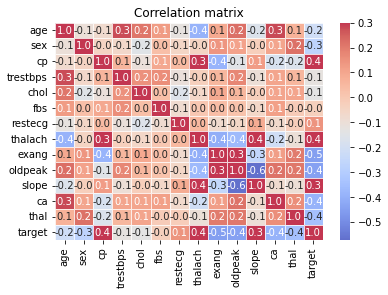

In [7]:
df1 = df.copy()
from sklearn.preprocessing import LabelEncoder
cols = df1.columns

encoder = LabelEncoder()
for col in cols:
    encoder.fit(df1[col])
    df1[col] = encoder.transform(df1[col])

corr = df1.corr()
sns.heatmap(corr,
            cmap = 'coolwarm',
            vmax=.3,
            annot = True,
            linewidths = 0.5,
            fmt = ".01f",
            alpha = 0.8)

plt.title('Correlation matrix')
plt.show()

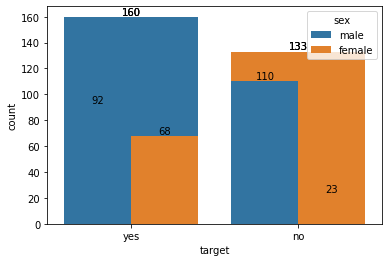

In [9]:
df1 = sns.countplot(x=df['target'])
df1.bar_label(df1.containers[0])
df2 = sns.countplot(x=df['target'],hue=df['sex'])
df2.bar_label(df2.containers[0])
for container in df2.containers:
    df2.bar_label(container)

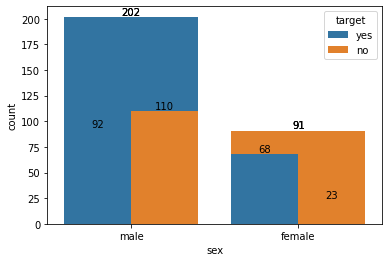

In [8]:
df1 = sns.countplot(x=df['sex'])
df1.bar_label(df1.containers[0])
df2 = sns.countplot(x=df['sex'],hue=df['target'])
df2.bar_label(df2.containers[0])
for container in df2.containers:
    df2.bar_label(container)

In [138]:
def encode_df(dataframe):
    le = LabelEncoder()
    for col in dataframe.columns:
        dataframe[col] = le.fit_transform(dataframe[col])
    return dataframe
df_encoded = encode_df(df)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,29,1,3,31,62,1,0,47,0,22,0,0,1,1
1,3,1,2,22,78,0,1,82,0,32,0,0,2,1
2,7,0,1,22,33,0,0,69,0,14,2,0,2,1
3,22,1,1,14,65,0,1,74,0,8,2,0,2,1
5,23,1,0,28,23,0,1,45,0,4,1,0,1,1


### Separate dataset by x and y

In [139]:
from sklearn.model_selection import train_test_split
encoded_df = df.copy()
x = df.drop(['target'], axis = 1)
y = df['target']

### Create Test and Train splits

In [140]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_std = scaler.fit_transform(x)
# We will follow an 80-20 split pattern for our training and test data, respectively
x_train,x_test,y_train,y_test = train_test_split(x, y, test_size=0.2, random_state = 0)

### PREPROCESSING- Calculating actual disparate impact on testing values from original dataset
Disparate Impact is defined as the ratio of favorable outcomes for the unprivileged group divided by the ratio of favorable outcomes for the privileged group. It is a Preprocessing technique used to mitigate bias in training data that edits feature values increase group fairness while preserving rank-ordering within groups.
The acceptable threshold is between .8 and 1.25, with .8 favoring the privileged group, and 1.25 favoring the unprivileged group.

In [141]:
Disparate_test = x_test.copy()
Disparate_test['target_Actual'] = y_test
Disparate_test.shape

(59, 14)

In [142]:
# Privileged group: Males (1)
# Unprivileged group: Females (0)
male_df1 = Disparate_test[Disparate_test['sex'] == 1]
num_of_privileged1 = male_df1.shape[0]
female_df1 = Disparate_test[Disparate_test['sex'] == 0]
num_of_unprivileged1 = female_df1.shape[0]

In [143]:
unprivileged_outcomes1 = female_df1[female_df1['target_Actual'] == 1].shape[0]
unprivileged_ratio1 = unprivileged_outcomes1/num_of_unprivileged1
unprivileged_ratio1

0.65

In [144]:
privileged_outcomes1 = male_df1[male_df1['target_Actual'] == 1].shape[0]
privileged_ratio1 = privileged_outcomes1/num_of_privileged1
privileged_ratio1

0.358974358974359

In [145]:
# Calculating disparate impact
disparate_impact = unprivileged_ratio1 / privileged_ratio1
print("Disparate Impact, Sex vs. Predicted target Status: " + str(disparate_impact))

Disparate Impact, Sex vs. Predicted target Status: 1.8107142857142857


### Arrived at a disparate income ratio of 1.8. This indicates that the actual test split favors the privileged group (males), as a disparate income ratio of 1 indicates complete equality.


### Applying the Disparate Impact Remover to the dataset

In [146]:
# We are going to be using the dataset with categorical features encoded, encoded_df
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,29,1,3,31,62,1,0,47,0,22,0,0,1,1
1,3,1,2,22,78,0,1,82,0,32,0,0,2,1
2,7,0,1,22,33,0,0,69,0,14,2,0,2,1
3,22,1,1,14,65,0,1,74,0,8,2,0,2,1
5,23,1,0,28,23,0,1,45,0,4,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,29,0,0,17,27,0,1,33,1,0,1,0,2,0
298,23,0,0,28,69,0,1,21,1,2,1,0,3,0
299,11,1,3,8,91,0,1,30,0,12,1,0,3,0
300,34,1,0,30,24,1,1,38,0,31,1,2,3,0


# Mitigating Bias with AI Fairness 360

To mitigate bias, I utilized an open-source toolkit/Python package of metrics and algorithms introduced by IBM ResearcH. Bias mitigation algorithms can be generally categorized into three categories: pre-process (which affects the data, prior to training), in-process (which affects the classifier itself), and post-process (which affects the prediction labels that are output). I chose to apply a pre-processing algorithm offered by the AIF360 package, DisparateImpactRemover, which edits feature values to increase group fairness. 

saw that AIF360 requires users to convert the Pandas dataframe into a data type they call a BinaryLabelDataSet before applying the disparate impact removal algorithm:

In [147]:
#import aif360
from aif360.algorithms.preprocessing import DisparateImpactRemover
# binaryLabelDataset = aif360.datasets.BinaryLabelDataset(
#     df=yourDataFrameHere,
#     label_names=['yourOutcomeLabelHere'],
#     protected_attribute_names=['yourProtectedClassHere'])
# Must be a binaryLabelDataset
binaryLabelDataset = aif360.datasets.BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=encoded_df,
    label_names=['target'],
    protected_attribute_names=['sex'])
di = DisparateImpactRemover(repair_level = 1.0)
dataset_transf_train = di.fit_transform(binaryLabelDataset)
transformed_Disparate = dataset_transf_train.convert_to_dataframe()[0]
transformed_Disparate

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,29.0,1.0,3.0,31.0,62.0,1.0,0.0,45.0,0.0,15.0,0.0,0.0,1.0,1.0
1,3.0,1.0,2.0,22.0,78.0,0.0,1.0,72.0,0.0,28.0,0.0,0.0,2.0,1.0
2,4.0,0.0,1.0,21.0,26.0,0.0,0.0,69.0,0.0,14.0,2.0,0.0,2.0,1.0
3,22.0,1.0,1.0,13.0,65.0,0.0,1.0,67.0,0.0,6.0,2.0,0.0,2.0,1.0
5,23.0,1.0,0.0,27.0,23.0,0.0,1.0,45.0,0.0,3.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,27.0,0.0,0.0,17.0,19.0,0.0,1.0,25.0,1.0,0.0,1.0,0.0,2.0,0.0
298,21.0,0.0,0.0,28.0,58.0,0.0,1.0,15.0,1.0,2.0,1.0,0.0,3.0,0.0
299,11.0,1.0,3.0,7.0,90.0,0.0,1.0,30.0,0.0,8.0,1.0,0.0,3.0,0.0
300,34.0,1.0,0.0,29.0,23.0,1.0,1.0,37.0,0.0,26.0,1.0,2.0,3.0,0.0


### Train a model using the dataset that underwent the pre-processing

In [148]:
x_trans = transformed_Disparate.drop(['target'], axis = 1)
y = transformed_Disparate['target']
scaler = StandardScaler()
data_std = scaler.fit_transform(x_trans)
x_trans_train,x_trans_test,y_trans_train,y_trans_test = train_test_split(x_trans, y, test_size=0.1, random_state = 0)

In [149]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=1000)


In [151]:
logreg1 = model.fit(x_trans_train, y_trans_train)
print("Training set score of LogisticRegression: {:.3f}".format(logreg1.score(x_trans_train, y_trans_train)))

Training set score of LogisticRegression: 0.878


### Calculating disparate impact on predicted values by model trained on transformed dataset

In [126]:
# We now need to add this array into x_test as a column for when we calculate the fairness metrics.
y_trans_pred = model.predict(x_trans_test)
x_trans_test['target_Predicted'] = y_trans_pred
transformed_output = x_trans_test


Disparate Impact is defined as the ratio of favorable outcomes for the unpriviliged group divided by the ratio of favorable outcomes for the priviliged group. The acceptable threshold is between .8 and 1.25, with .8 favoring the priviliged group, and 1.25 favoring the unpriviliged group.

In [127]:
# Privileged group: Males (1)
# Unprivileged group: Females (0)
male_df2 = transformed_output[transformed_output['sex'] == 1]
num_of_privileged2 = male_df2.shape[0]
female_df2 = transformed_output[transformed_output['sex'] == 0]
num_of_unprivileged2 = female_df2.shape[0]

In [128]:
unprivileged_outcomes2 = female_df2[female_df2['target_Predicted'] == 1].shape[0]
unprivileged_ratio2 = unprivileged_outcomes2/num_of_unprivileged2
unprivileged_ratio2

0.6666666666666666

In [129]:
privileged_outcomes2 = male_df2[male_df2['target_Predicted'] == 1].shape[0]
privileged_ratio2 = privileged_outcomes2/num_of_privileged2
privileged_ratio2

0.6190476190476191

In [130]:
# Calculating disparate impact
disparate_impact = unprivileged_ratio2 / privileged_ratio2
print("Disparate Impact, Sex vs. Predicted target Status: " + str(disparate_impact))

Disparate Impact, Sex vs. Predicted target Status: 1.0769230769230769
